In [17]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
path="path2TRACKMLdata"
hits=pd.read_csv(path+"event000029500-hits.csv",usecols=["hit_id","x","y","z","layer_id","volume_id"])
truth=pd.read_csv(path+"event000029500-truth.csv")
particles=pd.read_csv(path+"event000029500-particles.csv")
df_ht=pd.merge(hits,truth,on="hit_id")
df_data=pd.merge(df_ht,particles,on="particle_id")

In [4]:
from annoy import AnnoyIndex
def buildAnnoyIndex(data,metric="angular",ntrees=10):
    f = data.shape[1]
    t = AnnoyIndex(f,metric)  
    for i,d in enumerate(data):
        t.add_item(i, d)
    t.build(ntrees) # more trees are slower to build but slightly more accurate
    return t

In [6]:
index=buildAnnoyIndex(df_data[["x","y","z"]].values,metric="angular",ntrees=4)

Size of leading particle per bucket : 
4
13
7
3
8
5
2
3
2
2


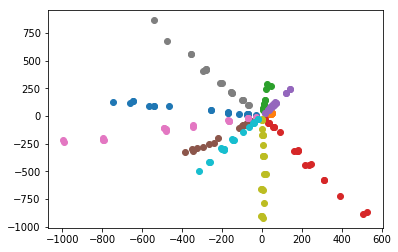

In [45]:
# Generate N buckets and plot them in x,y view. List the size of the leading particle in each bucket.
N=10
print("Size of leading particle per bucket : ")
for h in range(N):
    n=random.choice(range(len(df_data))) # choice of query position influcences bucket quality (sometime a lot)
    bucket_idx=np.array(index.get_nns_by_item(n,20))
    bucket=df_data.iloc[bucket_idx]
    print (Counter(bucket.particle_id).most_common(1)[0][1])
    plt.plot(bucket.x,bucket.y,"o")
plt.show()

In [24]:
#checking distribution of leading particles in N random buckets
#one can play with position of query, pT cut... for different evaluations
def dist_leading_size(df_data,index,BS=20,N=1000):   
    dist_leading=[]
    for h in range(N):
        n=random.choice(range(len(df_data))) # choice of query position influcences bucket quality (sometime a lot)
        bucket_idx=np.array(index.get_nns_by_item(n,BS))
        bucket=df_data.iloc[bucket_idx]
        dist_leading.append(Counter(bucket.particle_id).most_common(1)[0][1])
    return dist_leading

In [25]:
dist_leading=dist_leading_size(df_data,index)

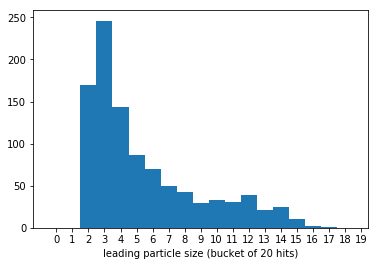

In [39]:
N=1000
c_bins=np.arange(0,20,1) #to really see everything, change according to BS (bucket size)
plt.hist(dist_leading,bins=c_bins,align="left")
plt.xlabel("leading particle size (bucket of 20 hits)")
plt.xticks(c_bins)
plt.show()

In [40]:
%timeit  [np.array(index.get_nns_by_item(n,20)) for n in random.sample(range(1, len(df_data)), N) ]

23.6 ms ± 695 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
#pretty cool given its python